**Purpose:** To analyze a Xenium dataset (Tiny subset of Fresh Frozen Mosue Brain for Xenium Explorer Demo from the 10x Genomics) website using Seurat. Basic workflow was tested, but cell-type annotation with another package was not done\
**Author:** Tamim Ahsan\
**Date** January 14, 2026

# 1. Load packages and read the data

In [1]:
# Load the packages
library(tidyverse)
library(Seurat)
library(future)
library(SeuratObject)
library(sp)
plan("multisession", workers = 10)
options(future.globals.maxSize = 40 * 1024^3)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
# Read the data
path <- "Xenium/"
xen.obj <- LoadXenium(path, 
                     fov = "fov",
                     segmentations = "cell")
xen.obj

Cell_seg columns: cell_id

Adding default segmentation_method = 'cell'

Genome matrix has multiple modalities, returning a list of matrices for this genome

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
541 features across 36602 samples within 4 assays 
Active assay: Xenium (248 features, 0 variable features)
 1 layer present: counts
 3 other assays present: BlankCodeword, ControlCodeword, ControlProbe
 1 spatial field of view present: fov

In [3]:
# Check the default assay
DefaultAssay(xen.obj)

[1] "Xenium"

# 2. QC and basic visualization

In [4]:
# Remove cells with 0 counts
print(paste0("The number of cells before filtering = ", ncol(xen.obj)))
xen.obj <- subset(xen.obj, subset = nCount_Xenium > 0)
print(paste0("The number of cells after filtering = ", ncol(xen.obj)))

[1] "The number of cells before filtering = 36602"


Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”


[1] "The number of cells after filtering = 36553"


Warning message:
“Default search for "data" layer in "Xenium" assay yielded no results; utilizing "counts" layer instead.”


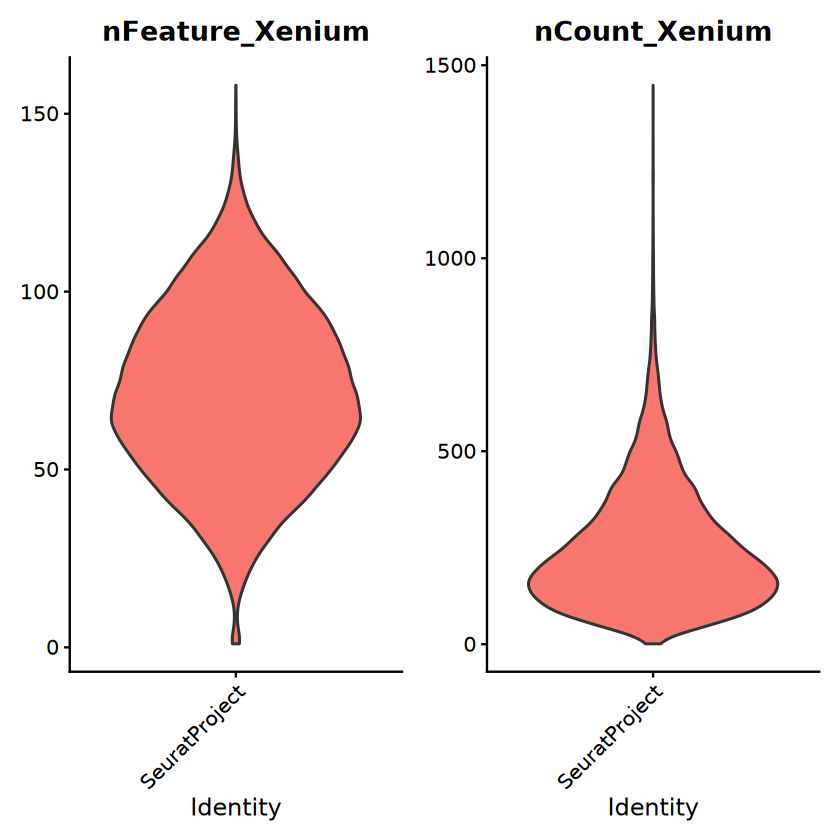

In [5]:
# Plotting the feature and transcript counts
VlnPlot(xen.obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)

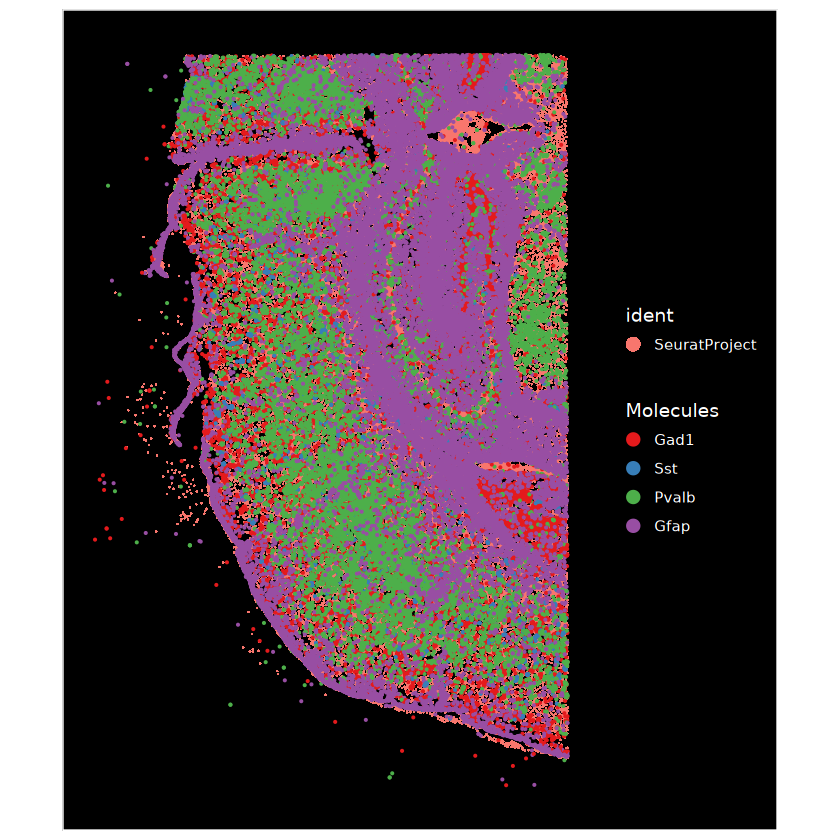

In [6]:
# Plot a couple of genes
ImageDimPlot(xen.obj, fov = "fov", molecules = c("Gad1", "Sst", "Pvalb", "Gfap"), nmols = 20000)

Warning message:
“No layers found matching search pattern provided”
Warning message in FetchData.Assay5(object = object[[DefaultAssay(object = object)]], :
“data layer is not found and counts layer is used”


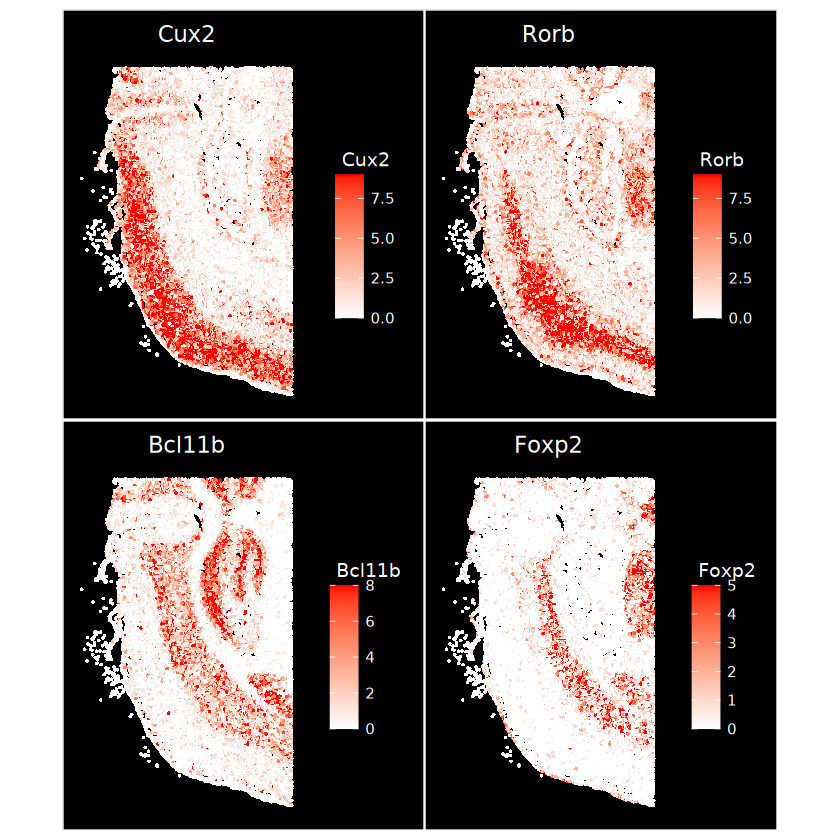

In [7]:
# Plot some layer-specific marker genes
ImageFeaturePlot(xen.obj, 
                 features = c("Cux2", "Rorb", "Bcl11b", "Foxp2"), 
                 max.cutoff = "q90", # for sharper contrast 
                 size = 0.75, 
                 cols = c("white", "red"))

In [8]:
# Zoom into a specific locaiton 
# Cell segmentation can be seen 
cropped.coords <- Crop(xen.obj[["fov"]],
                      x = c(1200, 2900),
                      y = c(3750, 4550),
                      coords = "plot")

xen.obj[["zoom"]] <- cropped.coords

DefaultBoundary(xen.obj[["zoom"]]) <- "segmentation"

Warning message:
“Key ‘Xenium_’ taken, using ‘zoom_’ instead”
Warning message:
“Adding image with unordered cells”


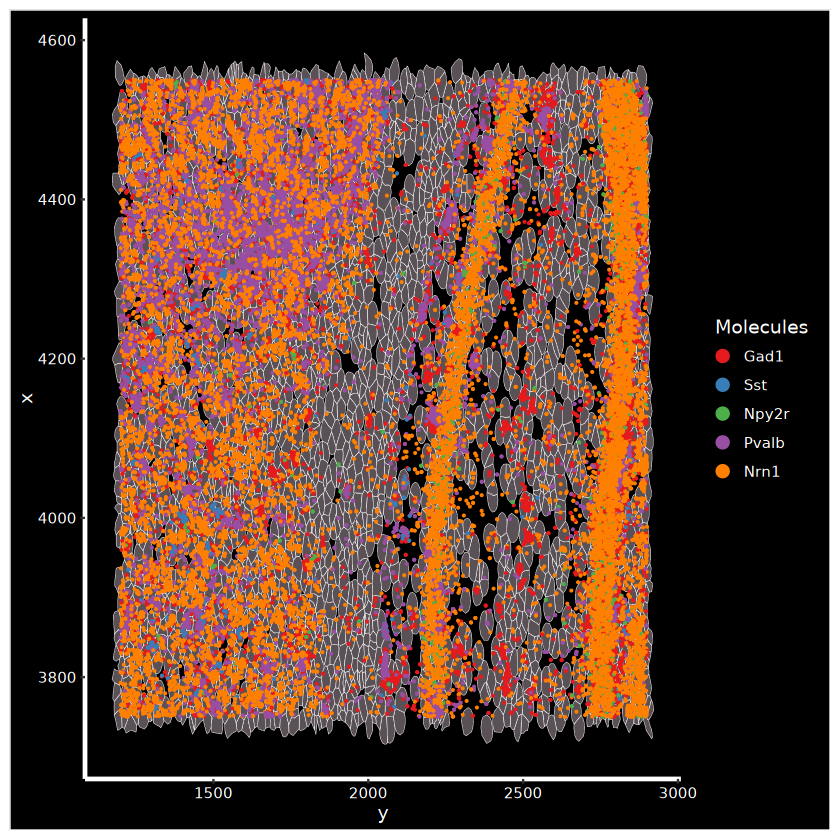

In [10]:
# Visualize the zoomed in region 
ImageDimPlot(xen.obj,
            fov = "zoom",
            axes = TRUE,
            border.color = "white",
            border.size = 0.1,
            cols = "polychrome",
            coord.fixed = FALSE,
            molecules = c("Gad1", "Sst", "Npy2r", "Pvalb", "Nrn1"),
            nmols = 10000)

# 3. Normalization, dimensionality reduction and clustering

In [11]:
# Normalization 
xen.obj <- SCTransform(xen.obj, assay = "Xenium")
xen.obj

Running SCTransform on assay: Xenium

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 248 by 36553

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 248 genes, 5000 cells

Second step: Get residuals using fitted parameters for 248 genes

Computing corrected count matrix for 248 genes

Calculating gene attributes

Wall clock passed: Time difference of 2.719323 mins

Determine variable features

Centering data matrix

Place corrected count matrix in counts slot

Set default assay to SCT



An object of class Seurat 
789 features across 36553 samples within 5 assays 
Active assay: SCT (248 features, 248 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 2 spatial fields of view present: fov zoom

In [14]:
# PCA
xen.obj <- RunPCA(xen.obj, npcs = 30, assay = "SCT", features = rownames(xen.obj))
xen.obj

PC_ 1 
Positive:  Slc17a7, Nrn1, Epha4, Neurod6, Nwd2, Gad1, Cpne4, Rasgrf2, Rims3, Lamp5 
	   2010300C02Rik, Dkk3, Slc17a6, Pvalb, Garnl3, Cpne6, Fhod3, Plcxd2, Gad2, Tmem132d 
	   Kcnh5, Dner, Calb1, Bhlhe22, Bcl11b, Nell1, Bdnf, Rasl10a, Satb2, Arc 
Negative:  Igf2, Dcn, Fmod, Slc13a4, Fn1, Aldh1a2, Col1a1, Ly6a, Cldn5, Spp1 
	   Gfap, Nr2f2, Gjb2, Cyp1b1, Acta2, Pecam1, Adgrl4, Pdgfra, Acvrl1, Kdr 
	   Cd93, Ccn2, Cobll1, Fgd5, Sox17, Igfbp5, Carmn, Lyz2, Pglyrp1, Emcn 
PC_ 2 
Positive:  Gjc3, Opalin, Sox10, Gfap, Clmn, Vwc2l, Zfp536, Sema6a, Gpr17, Gng12 
	   Tmem163, Prox1, Adamtsl1, Dpy19l1, Cobll1, Cdh20, Arhgef28, Igfbp5, Chrm2, Sema3d 
	   Carmn, Aqp4, Fign, Pdgfra, Cspg4, Ntsr2, Lyz2, Siglech, Adamts2, Rmst 
Negative:  Slc17a7, Fn1, Igf2, Nrn1, Cldn5, Epha4, Neurod6, Ly6a, Dcn, Rasgrf2 
	   Lamp5, Fmod, Aldh1a2, Dkk3, 2010300C02Rik, Slc13a4, Car4, Nwd2, Gad1, Pecam1 
	   Col1a1, Igfbp4, Spp1, Cpne4, Rims3, Igfbp6, Cpne6, Acvrl1, Calb1, Adgrl4 
PC_ 3 
Positive:  Slc13a4, Igf2

An object of class Seurat 
789 features across 36553 samples within 5 assays 
Active assay: SCT (248 features, 248 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 1 dimensional reduction calculated: pca
 2 spatial fields of view present: fov zoom

In [16]:
# UMAP
xen.obj <- RunUMAP(xen.obj, dims = 1:30)
xen.obj

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
06:01:07 UMAP embedding parameters a = 0.9922 b = 1.112

06:01:07 Read 36553 rows and found 30 numeric columns

06:01:07 Using Annoy for neighbor search, n_neighbors = 30

06:01:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:01:12 Writing NN index file to temp file /tmp/RtmpfZr5N4/file60d550c7196b

06:01:12 Searching Annoy index using 10 threads, search_k = 3000

06:01:15 Annoy recall = 100%

06:01:15 Commencing smooth kNN distance calibration using 10 threads
 with target n_neighb

An object of class Seurat 
789 features across 36553 samples within 5 assays 
Active assay: SCT (248 features, 248 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 2 dimensional reductions calculated: pca, umap
 2 spatial fields of view present: fov zoom

In [32]:
# Find KNN neighbors
xen.obj <- FindNeighbors(xen.obj, reduction = "pca", dims = 1:30)
xen.obj

Computing nearest neighbor graph

Computing SNN



An object of class Seurat 
789 features across 36553 samples within 5 assays 
Active assay: SCT (248 features, 248 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 2 dimensional reductions calculated: pca, umap
 2 spatial fields of view present: fov zoom

In [33]:
# Clustering 
xen.obj <- FindClusters(xen.obj, 
                        algorithm = 4, # Leiden 
                        resolution = 0.3)
xen.obj

Warning message in RunLeiden(object = object, leiden_method = leiden_method, leiden_objective_function = leiden_objective_function, :
“`random.seed` must be greater than 0 for leiden clustering, resetting `random.seed` to 1.”


An object of class Seurat 
789 features across 36553 samples within 5 assays 
Active assay: SCT (248 features, 248 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 2 dimensional reductions calculated: pca, umap
 2 spatial fields of view present: fov zoom

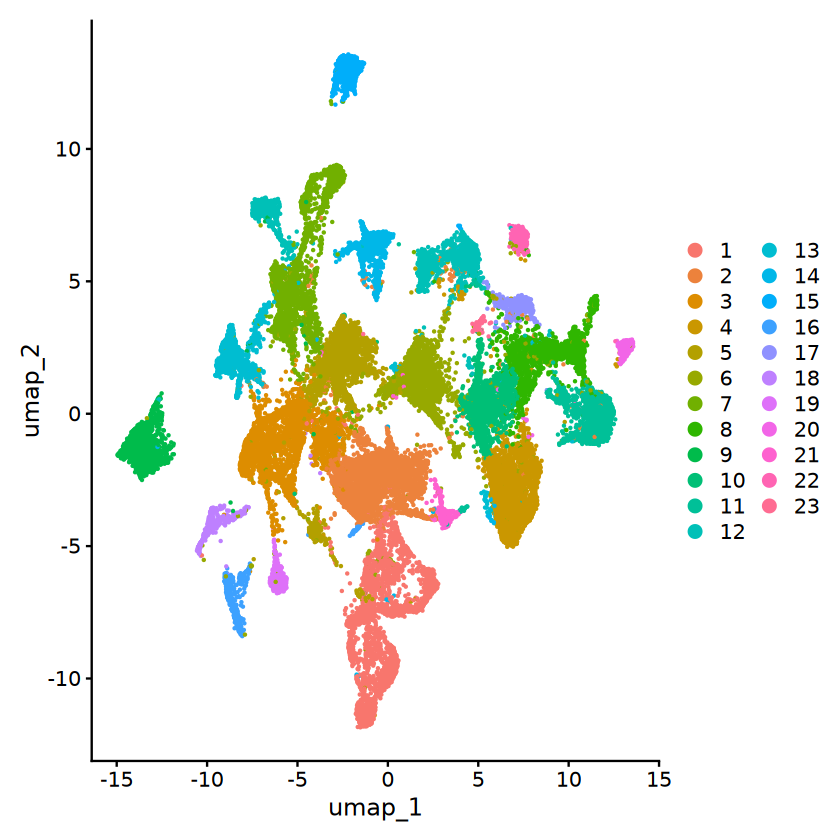

In [34]:
# Visualize the clusters
DimPlot(xen.obj)

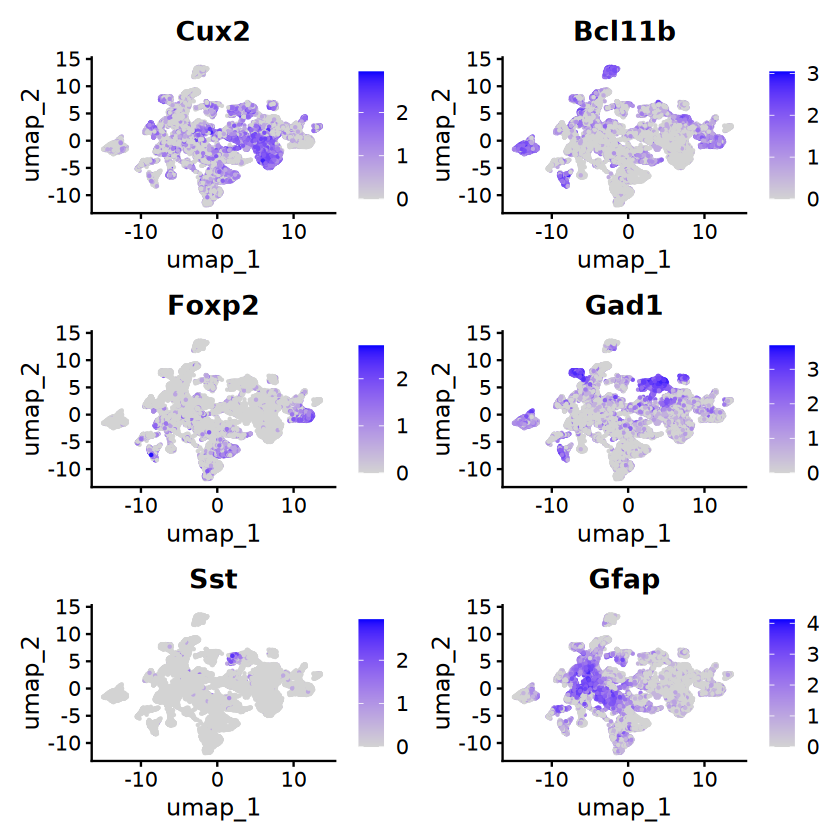

In [35]:
# Look at the expression level of some markers
FeaturePlot(xen.obj,
           features = c("Cux2", "Bcl11b", "Foxp2", "Gad1", "Sst", "Gfap"))

Warning message:
“No FOV associated with assay 'SCT', using global default FOV”


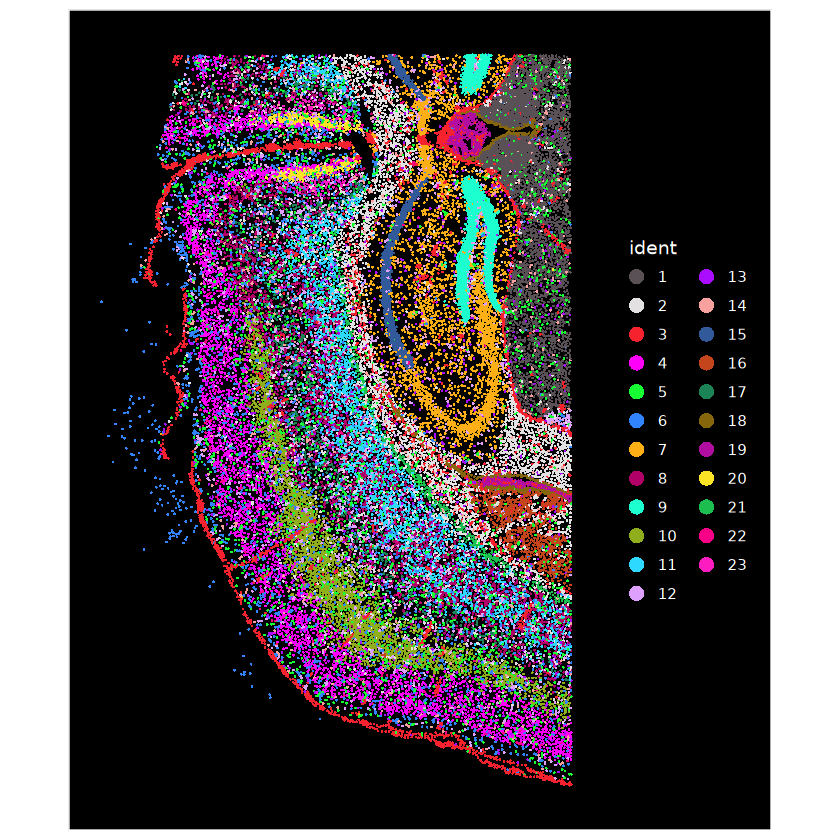

In [36]:
# Visualize cell positions by cluster levels
ImageDimPlot(xen.obj,
            cols = "polychrome",
            size = 0.5)

In [37]:
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: x86_64-conda-linux-gnu
Running under: SUSE Linux Enterprise Server 15 SP6

Matrix products: default
BLAS/LAPACK: /nexus/posix0/MPI-psych/g/dept-binder/mpsmgp/ahsant/software/miniforge3/envs/jupyter/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] future_1.68.0      Seurat_5.4.0       SeuratObject_5.3.0 sp_2.2-0          
 [5] lubridate_1.9.4    forcats_1.0.1      stringr_1.6.0      dplyr_1.1.4       
 [9] 